In [30]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
from functools import reduce
from scipy.stats import norm
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import GaussianMixture

import gmm.model

In [2]:
from ml_bme_scoring.transformer.legacy.sparse_vector_dataset_v1 import SparseVectorDimension
from ml_bme_scoring.mining.sparse_standard_scaler import SparseStandardScaler

In [4]:
import importlib
importlib.reload(gmm.model)

<module 'gmm.model' from '/usr/local/spark/python/gmm/model.py'>

In [3]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [4]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled

In [5]:
from gmm.model import zero_off_diagonal, remove_dim

def visualize_model(model, x_dim=0, y_dim=1, n=10000, cluster=None):
    if cluster is not None:
        counts = [n]
        gaussians = [model.gaussians[cluster]]
    else:
        total_weight = sum(model.weights)
        counts = [int((w / total_weight) * n) for w in model.weights]
        gaussians = model.gaussians

    d = reduce(lambda a, b: np.append(a, b, axis=0),
               [np.random.multivariate_normal(g.mu, g.sigma, c) for c, g in zip(counts, gaussians)])
    x = [r[x_dim] for r in d]
    y = [r[y_dim] for r in d]
    pyplot.scatter(x, y)


def visualize_null_2(model, null_dim, x_dim=0, y_dim=1, n=10000, cluster=None):
    if cluster is not None:
        counts = [n]
        gaussians = [model.gaussians[cluster]]
    else:
        total_weight = sum(model.weights)
        counts = [int((w / total_weight) * n) for w in model.weights]
        gaussians = model.gaussians

    mus = [g.mu for g in gaussians]
    sigmas = [zero_off_diagonal(g.sigma, [null_dim]) for g in gaussians]
    d = reduce(lambda a, b: np.append(a, b, axis=0),
               [np.random.multivariate_normal(mu, sigma, c) for c, mu, sigma in zip(counts, mus, sigmas)])
    x = [r[x_dim] for r in d]
    y = [r[y_dim] for r in d]
    pyplot.scatter(x, y)


def visualize_null_1(model, null_dim, x_dim=0, y_dim=1, n=10000, cluster=None):
    if cluster is not None:
        counts = [n]
        gaussians = [model.gaussians[cluster]]
    else:
        total_weight = sum(model.weights)
        counts = [int((w / total_weight) * n) for w in model.weights]
        gaussians = model.gaussians

    mus = [(np.delete(g.mu, null_dim), np.array([g.mu[null_dim]])) for g in gaussians]
    sigmas = [(remove_dim(g.sigma, null_dim), np.array([[g.sigma[null_dim][null_dim]]])) for g in gaussians]

    a = [(np.random.multivariate_normal(mu[0], sigma[0], c), np.random.multivariate_normal(mu[1], sigma[1], c))
         for c, mu, sigma in zip(counts, mus, sigmas)]
    d = [np.append(np.append(other_vec[:null_dim], null_vec, axis=0), other_vec[null_dim:], axis=0)
         for other_dims_ds, null_dim_ds in a
         for other_vec, null_vec in zip(other_dims_ds, null_dim_ds)]

    x = [r[x_dim] for r in d]
    y = [r[y_dim] for r in d]
    pyplot.scatter(x, y)


def visualize_null_3(model, null_dim, x_dim=0, y_dim=1, n=10000, cluster=None):
    if cluster is not None:
        counts = [n]
        gaussians = [model.gaussians[cluster]]
    else:
        total_weight = sum(model.weights)
        counts = [int((w / total_weight) * n) for w in model.weights]
        gaussians = model.gaussians

    other_dims_ds = reduce(lambda a, b: np.append(a, b, axis=0),
                           [np.random.multivariate_normal(np.delete(g.mu, null_dim), remove_dim(g.sigma, null_dim), c)
                            for c, g in zip(counts, gaussians)])

    null_dim_ds = shuffle(reduce(lambda a, b: np.append(a, b, axis=0),
        [np.random.multivariate_normal(np.array([g.mu[null_dim]]), np.array([[g.sigma[null_dim][null_dim]]]), c)
         for c, g in zip(counts, gaussians)]))
    
    d = [np.append(np.append(other_vec[:null_dim], null_vec, axis=0), other_vec[null_dim:], axis=0)
         for other_vec, null_vec in zip(other_dims_ds, null_dim_ds)]

    x = [r[x_dim] for r in d]
    y = [r[y_dim] for r in d]
    pyplot.scatter(x, y)


In [26]:
unit = 0.50
on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 25000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 50000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 50000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

independent_rvs = [norm(loc=-1.0, scale=2.0), norm(loc=0.0, scale=0.5), 
                   norm(loc=-1.0, scale=1.0), norm(loc=2.0, scale=0.5)]

In [29]:
# data = reduce_correlation(shuffle(rv1, rv2, rv3, rv4), [0.75, 0.0, 0.0])
# data = sc.parallelize([Vectors.dense(np.append(x, independent_rvs[np.random.randint(0, 2)].rvs())) 
#                        for x in data])

modeling_service = gmm.model.ModelingService(data, max_iterations=200)
full_model = modeling_service.get_gmm(4)
# print(modeling_service.get_stats(4))

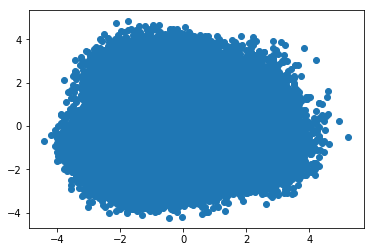

In [28]:
x = data.map(lambda v: v[0]).collect()
y = data.map(lambda v: v[1]).collect()
pyplot.scatter(x,y)

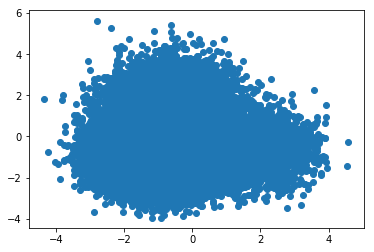

In [31]:
visualize_model(full_model, n=100000)

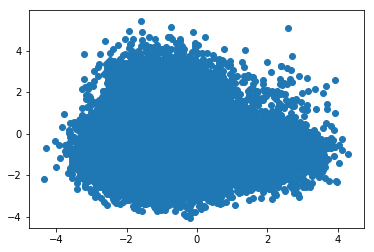

In [32]:
visualize_null_3(full_model, 1, n=100000)

## K-tuning using gain in log likelihood

In [9]:
from pyspark.sql import Row

models = []
results = []
n = data.count()
d = 4
for i in range(1,10):
  model = GaussianMixture.train(data, i)
  models.append(model)
  ll, p_values = log_likelihood_2(model, data)
  p = float((d*(d+1)/2.0)*i + i)
  bic = float(np.log(n)*p - 2*ll)
  aic = float(2*p - 2*ll)
  results.append(Row(k=i, ll=float(ll), bic=bic, aic=aic, p_values=[float(p) for p in p_values]))

[-1723816.10335661 -1747573.61591564 -1771145.70119122 -1836063.98274143
 -1732033.37785021]
[-1717323.26246946 -1736159.09863704 -1760731.6902329  -1796214.69778217
 -1725543.57114666]
[-1708273.86395669 -1728519.89911291 -1752688.87935763 -1787765.25047603
 -1719713.65675741]
[-1706533.35247959 -1726828.06132709 -1750113.70107617 -1786175.64347773
 -1725114.70673793]
[-1706011.7220369  -1720825.28024652 -1741035.35396039 -1785879.88761325
 -1725339.53707599]
[-1706082.68663437 -1715871.1711803  -1741389.99941415 -1785697.86229021
 -1721345.32757171]
[-1705940.54106405 -1724328.70622291 -1737042.71467506 -1776218.1951313
 -1722193.62831841]
[-1705682.07881474 -1721515.1642646  -1740796.71936625 -1779473.67427251
 -1721668.05907534]
[-1705674.24507534 -1722362.78743711 -1737962.38261963 -1766601.10673732
 -1722486.88601074]


In [10]:
p_values = [chi2.sf(-2*(results[i-1].ll - results[i].ll), df=d*(d+3)/2.0) for i in range(1, len(results))]
print(p_values)

[0.0, 0.0, 0.0, 8.1402331507547386e-214, 1.0, 2.211169486216714e-52, 2.3904611078300201e-101, 0.33409984487413497]


In [11]:
[results[i-1].ll - results[i].ll for i in range(1, len(results))]

[-6492.840887148166,
 -9049.398512767628,
 -1740.511477104621,
 -521.6304426859133,
 70.9645974682644,
 -142.1455703151878,
 -258.462249313714,
 -7.833739404100925]

In [12]:
display(results)

## P-value estimate using Likelihood Ratio Test

In [15]:
model = GaussianMixture.train(data, 4)

In [16]:
log_likelihood_1(model, data)

In [17]:
log_likelihood_2(model, data)

In [18]:
from pyspark.sql import Row

results = []
d = 4
for i in range(2,10):
  model = GaussianMixture.train(data, 3)
  ll, p_values = log_likelihood(model, data)
  p = float((d*(d+1)/2.0)*i + i)
  n = 45000.0
  bic = float(np.log(n)*p - 2*ll)
  aic = float(2*p - 2*ll)
  results.append(Row(k=i, ll=float(ll), bic=bic, aic=aic, p_values=[float(p) for p in p_values]))

In [19]:
results

In [20]:
d = 4
i, j = 0, 2

chi2.sf(-2 * (results[i].ll - results[j].ll), df=(j-i)*(d*(d+3)/2))

In [21]:
display(results)